# Lab 6 - Alvaro Austin

## Soal 1

### Part A

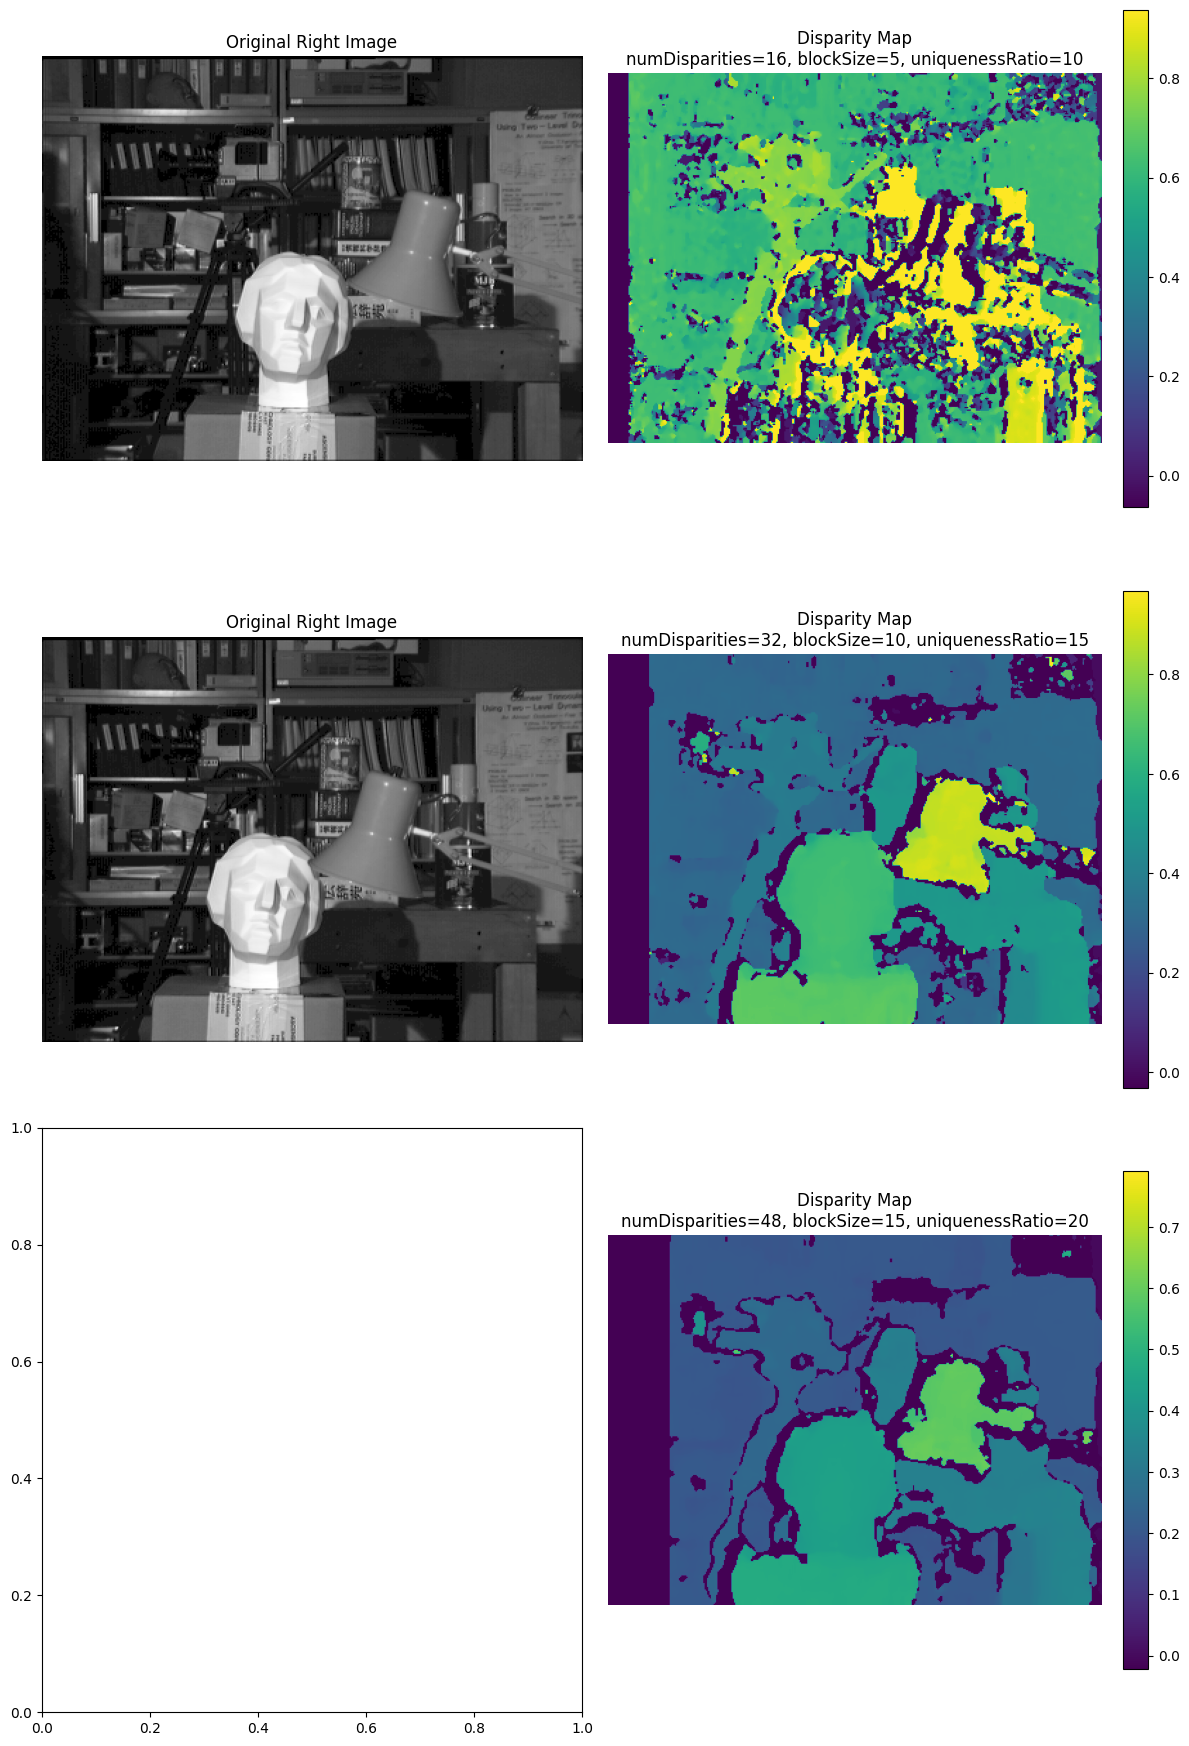

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_disparity_map(imgL, imgR, params=None):
    # Set default parameter values
    default_params = {
        'minDisparity': 0,
        'numDisparities': 16*6,
        'blockSize': 7,
        'uniquenessRatio': 15,
    }

    if params:
        default_params.update(params)

    stereo = cv2.StereoSGBM_create(**default_params)
    disparity = stereo.compute(imgL, imgR)

    disparity = ((disparity.astype(np.float32) / 16) - default_params['minDisparity']) / default_params['numDisparities']
    return disparity

parameters = [
    {
        "numDisparities": 16,
        "blockSize": 5,
        "uniquenessRatio": 10
    },
    {
        "numDisparities": 32,
        "blockSize": 10,
        "uniquenessRatio": 15
    },
    {
        "numDisparities": 48,
        "blockSize": 15,
        "uniquenessRatio": 20
    }
]

imgL = cv2.imread('tsukuba_l.png',cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('tsukuba_r.png', cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(len(parameters), 2, figsize=(12, 6 * len(parameters)))

for i, param in enumerate(parameters):
    result = compute_disparity_map(imgL, imgR, param)

    # Display original left and right images
    if i == 0:
      axes[i, 0].imshow(imgL, cmap='gray')
      axes[i, 0].set_title("Original Right Image")
      axes[i, 0].axis('off')
    elif i == 1:
      axes[i, 0].imshow(imgR, cmap='gray')
      axes[i, 0].set_title("Original Right Image")
      axes[i, 0].axis('off')

    # Display the disparity map with colorbar
    disp_plot = axes[i, 1].imshow(result, cmap='viridis')
    fig.colorbar(disp_plot, ax=axes[i, 1], fraction=0.046, pad=0.04)
    axes[i, 1].set_title(f"Disparity Map\nnumDisparities={param['numDisparities']}, blockSize={param['blockSize']}, uniquenessRatio={param['uniquenessRatio']}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Part B

Fungsi Parameter blockSize:
- `blockSize` menentukan ukuran blok atau area lokal yang dibandingkan antara dua gambar untuk menghitung disparitas. Dengan kata lain, ini adalah ukuran dari wilayah lokal yang digunakan untuk mencocokkan fitur antara dua citra. Pada tutorial dikatakan bahwa ukuran blok yang digunakan untuk mencocokkan piksel di kedua gambar. Blok yang lebih besar memberikan hasil yang lebih halus tetapi mungkin kehilangan detail.


Pengaruh Parameter blockSize:
- `blockSize` kecil: Jika `blockSize` terlalu kecil, hasil peta disparitas akan memiliki lebih banyak detail, tetapi cenderung lebih rentan atau vulnerable terhadap noise. Hal ini dapat menghasilkan peta yang kurang halus dan membuat area yang datar terlihat berbintik-bintik atau tidak konsisten.
- `blockSize` besar: Jika `blockSize` terlalu besar hasil peta disparitas akan lebih halus, tetapi dapat membuat hilangnya detail. Fitur-fitur halus atau tepi-tepi tajam mungkin tidak terdeteksi dengan baik, karena blok yang lebih besar mengaburkan detail-detail kecil dan membuatnya kurang sensitif terhadap variasi lokal.

Fungsi parameter `numDisparities`:

Jangkauan disparitas yang dicari, harus kelipatan 16. Hal ini yang secara efektif mengontrol rentang kedalaman yang dapat dideteksi. Jika `numDisparities` terlalu kecil, algoritma mungkin tidak mampu mencocokkan area yang memiliki kedalaman yang lebih bervariasi, karena rentang disparitas terbatas. Ini dapat menyebabkan kehilangan informasi atau bagian dari peta disparitas yang kosong. Dilain sisi, apabila `numDisparities` lebih besar, rentang kedalaman yang lebih luas dapat ditangkap, sehingga menghasilkan peta disparitas yang lebih rinci di area dengan variasi kedalaman yang besar

### Part C

In [7]:
import plotly.graph_objects as go

disparity_choose = compute_disparity_map(imgL, imgR, parameters[1])

def generate_3d_point_cloud(disparity_map, imgL):
    h, w = imgL.shape[:2]
    focal_length = 0.8 * w  # Estimasi panjang fokus
    Q = np.float32([[1, 0, 0, -w / 2.0],
                    [0, -1, 0, h / 2.0],
                    [0, 0, 0, -focal_length],
                    [0, 0, 1, 0]])

    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
    mask = disparity_map > disparity_map.min()
    valid_points = points_3D[mask]
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)[mask]
    return valid_points, colors

def plot_interactive_point_cloud(valid_points, colors, downsample_factor=10):
    indices = np.random.choice(len(valid_points), len(valid_points)//downsample_factor, replace=False)
    points = valid_points[indices]
    point_colors = colors[indices]
    color_strings = [f'rgb({r},{g},{b})' for r, g, b in point_colors]

    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=color_strings,
            opacity=0.8
        )
    )])

    fig.update_layout(
        scene=dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=800,
        title='Interactive 3D Point Cloud'
    )

    return fig

valid_points, colors = generate_3d_point_cloud(disparity_choose, imgL)
fig = plot_interactive_point_cloud(valid_points, colors)
fig.show()

### Part D

Peta disparitas menunjukkan perbedaan posisi suatu piksel antara dua gambar stereo (gambar kiri dan kanan) pada sumbu horizontal. Dalam proses stereo vision, setiap piksel di gambar kiri dicocokkan dengan piksel di gambar kanan. Disparitas tersebut proporsional dengan kedalaman objek dalam gambar. Hal ini berarti, objek dengan nilai disparitas tinggi (perbedaan posisi piksel lebih besar) biasanya lebih dekat ke kamera, sementara objek dengan nilai disparitas rendah (perbedaan posisi piksel kecil) lebih jauh. Tidak hanya itu, disparitas yang sangat rendah atau tidak valid menunjukkan titik-titik yang tidak memiliki kecocokan yang baik antara kedua gambar, menyebabkan informasi kedalaman yang tidak dapat diandalkan untuk titik tersebut.

Matriks Q mengonversi nilai disparitas menjadi koordinat spasial dalam dunia nyata (X, Y, Z). Matriks ini menyertakan informasi panjang fokus, baseline, dan posisi tengah gambar, yang memungkinkan konversi ke sistem koordinat 3D.

## Soal 2

### Part A

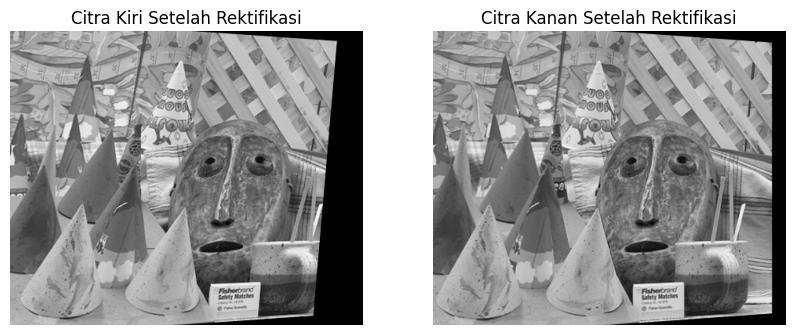

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Buat terlebih dahulu citra grayscale untuk left dan right-nya
img_left = cv2.imread('cones_left.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('cones_right.png', cv2.IMREAD_GRAYSCALE)

# Menggunakan ORB untuk mendeteksi fitur dan menghitung deskriptor
orb = cv2.ORB_create(nfeatures=2000)
keypoints_left, descriptors_left = orb.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = orb.detectAndCompute(img_right, None)

# Pencocokan deskriptor menggunakan BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_left, descriptors_right)
matches = sorted(matches, key=lambda x: x.distance)

# Menyusun pasangan titik-titik yang cocok
pts_left = np.float32([keypoints_left[m.queryIdx].pt for m in matches])
pts_right = np.float32([keypoints_right[m.trainIdx].pt for m in matches])

# Menghitung matriks fundamental
F, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_RANSAC)

# Memilih inlier points
pts_left_inliers = pts_left[mask.ravel() == 1]
pts_right_inliers = pts_right[mask.ravel() == 1]

# Melakukan rektifikasi
h, w = img_left.shape
retval, H1, H2 = cv2.stereoRectifyUncalibrated(pts_left_inliers, pts_right_inliers, F, imgSize=(w, h))

# Menerapkan transformasi rektifikasi
img_left_rectified = cv2.warpPerspective(img_left, H1, (w, h))
img_right_rectified = cv2.warpPerspective(img_right, H2, (w, h))

# Menampilkan hasil
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_left_rectified, cmap='gray')
plt.title('Citra Kiri Setelah Rektifikasi')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_right_rectified, cmap='gray')
plt.title('Citra Kanan Setelah Rektifikasi')
plt.axis('off')
plt.show()


Langkah-langkah pra-pemrosesan pada kode ini mencakup tahapan berikut, yang memastikan bahwa geometri epipolar telah ditangani dengan benar:

1. Konversi ke Grayscale: Citra kiri dan kanan diubah menjadi grayscale agar fitur lebih mudah diekstraksi dan cocokkan. Ini mengurangi data yang perlu diproses.

2. Ekstraksi Fitur dengan ORB: Fitur pada kedua citra dideteksi menggunakan ORB (Oriented FAST and Rotated BRIEF), yang menghasilkan titik kunci dan deskriptor yang dapat dicocokkan.

3. Pencocokan Fitur dengan BFMatcher: Menggunakan Brute-Force Matcher, deskriptor dari kedua citra dicocokkan dengan menghitung jarak Hamming. Hanya pasangan yang terbaik (dengan jarak terpendek) yang dipilih.

4. Konstruksi Fundamental Matrix (Matriks Fundamental): Titik yang cocok dari citra kiri dan kanan digunakan untuk menghitung matriks fundamental F menggunakan metode RANSAC untuk memfilter outlier. Matriks ini mendefinisikan hubungan epipolar antara dua citra.

5. Rektifikasi Citra: Berdasarkan matriks fundamental dan inlier points, fungsi stereoRectifyUncalibrated menghitung matriks transformasi rektifikasi `H1` dan `H2`, yang memastikan kedua citra berada dalam geometri epipolar yang sejajar, sehingga epilines pada kedua citra menjadi horizontal.

6. Transformasi Rektifikasi: Kedua citra kiri dan kanan diterapkan dengan matriks rektifikasi, yang menghasilkan citra yang sejajar secara epipolar. Citra hasil ini memungkinkan pembuatan peta disparitas dengan lebih akurat, karena fitur yang sesuai sekarang berada di garis yang sama (horizontal).

### Part B


Rektifikasi citra merupakan langkah krusial dalam sistem penglihatan stereo karena menyelaraskan kedua citra sehingga fitur yang sama pada citra kiri dan kanan berada pada garis horizontal yang sama (garis epipolar). Ini sangat penting untuk perhitungan peta disparitas yang akurat, yang merupakan dasar dalam estimasi kedalaman.

Berikut adalah alasan yang memperkuat mengapa rektifikasi citra sangat penting untuk dilakukan:
1. Penyederhanaan proses pencocokan: melalui rektifikasi, titik-titik yang sesuai pada kedua citra akan sejajar secara horizontal, sehingga pencarian titik-titik yang cocok dapat dibatasi hanya pada satu baris yang sama.
2. Mengurangi error dalam pencocokan: melalui rektifikasi, memastikan bahwa titik yang sesuai berada di garis epipolar yang sama, yang mengurangi kesalahan dalam pencocokan karena setiap titik hanya perlu dicocokkan secara horizontal. Tanpa rektifikasi, titik-titik yang seharusnya cocok bisa berada di lokasi yang berbeda-beda, yang meningkatkan resiko kesalahan pencocokan dan ketidakakuratan dalam perhitungan peta disparitas.
3. Peningkatan akurasi estimasi kedalaman: Peta disparitas yang dihasilkan dari citra yang telah direktifikasi memiliki keakuratan yang lebih tinggi karena fitur yang sesuai berada pada posisi horizontal yang benar. Disparitas yang akurat penting dalam estimasi kedalaman, karena kesalahan kecil dalam pencocokan dapat menghasilkan error besar pada perhitungan kedalaman, terutama pada objek yang dekat dengan kamera.

### Part C

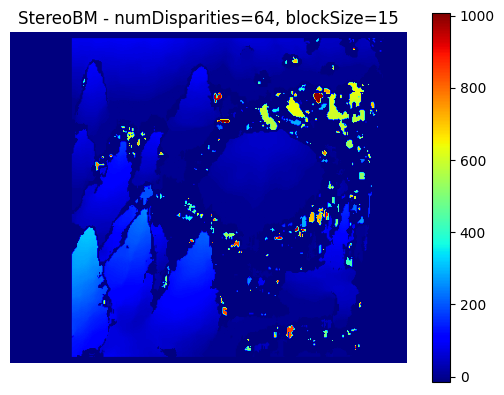

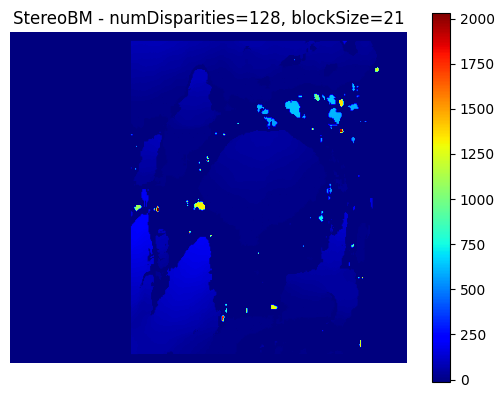

In [29]:
# Menggunakan StereoBM untuk menghitung peta disparitas
stereo_bm = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity_bm = stereo_bm.compute(img_left_rectified, img_right_rectified)

# Menampilkan hasil peta disparitas
plt.imshow(disparity_bm, cmap='jet')
plt.colorbar()
plt.title(f'StereoBM - numDisparities={64}, blockSize={15}')
plt.axis('off')
plt.show()

# Menggunakan StereoBM untuk menghitung peta disparitas
stereo_bm = cv2.StereoBM_create(numDisparities=128, blockSize=21)
disparity_bm = stereo_bm.compute(img_left_rectified, img_right_rectified)

# Menampilkan hasil peta disparitas
plt.imshow(disparity_bm, cmap='jet')
plt.colorbar()
plt.title(f'StereoBM - numDisparities={128}, blockSize={21}')
plt.axis('off')
plt.show()

### Part D

Pada hasil peta disparitas di atas, kita bisa melihat bahwa area dengan tekstur yang jelas menghasilkan disparitas yang lebih akurat, sementara area tanpa tekstur atau area dengan pola berulang cenderung memiliki disparitas yang kurang konsisten atau noisy.

Analisa:

Area Bertekstur vs. Area Tanpa Tekstur:

- Pada area yang memiliki banyak tekstur (seperti tepi objek atau area dengan perubahan intensitas), StereoBM mampu mendeteksi perbedaan disparitas dengan baik, yang terlihat pada distribusi warna disparitas yang lebih jelas.

- Pada area tanpa tekstur, seperti background gambar, dapat dilihat bahwa disparitasnya tidak akurat. Hal ini karena metode pencocokan stereo berbasis blok seperti StereoBM mengalami kesulitan menemukan pasangan yang sesuai di area dengan sedikit atau tanpa variasi tekstur.

Pola berulang:

Pada pola berulang, seperti cone pada gambar, algoritma pencocokan stereo dapat menghasilkan kesalahan pencocokan (mismatch), di mana blok yang serupa tetapi tidak sesuai dianggap sebagai pasangan yang cocok. Ini menyebabkan error disparitas yang terlihat pada beberapa bagian peta disparitas.

Saran:

1. Menggunakan algoritma stereo yang lebih kompleks (StereoSGBM):
StereoSGBM (Semi-Global Block Matching) adalah algoritma pencocokan stereo yang menggabungkan pendekatan lokal dan semi-global untuk meningkatkan akurasi pencocokan. Dibandingkan dengan StereoBM, StereoSGBM dapat menangani area dengan tekstur rendah dan pola berulang lebih baik, karena memperhitungkan kontinuitas disparitas di sepanjang garis horizontal.

2. Menerapkan filter pasca-pemrosesan (Median Filter):
Setelah menghasilkan peta disparitas awal, kita bisa menerapkan filter median untuk menghaluskan peta disparitas tanpa mengurangi ketajaman tepi. Filter ini akan membantu mengurangi noise pada area dengan sedikit tekstur atau pola berulang, sehingga meningkatkan konsistensi hasil disparitas.

3. Penggabungan data dari kamera tambahan atau metode Depth Sensing lain:
Pada kondisi lingkungan yang sulit (seperti tekstur rendah atau pola berulang), menggunakan data dari kamera tambahan atau sensor kedalaman lain (seperti Lidar) dapat memberikan informasi tambahan untuk memperbaiki ketepatan disparitas.